<a href="https://colab.research.google.com/github/Clement-Moreau-Info/SAC2021/blob/main/Semantic_Trajectories_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Loading and Imports

In [1]:
!pip install gdown -q
!pip install scikit-learn-extra -q
!gdown https://drive.google.com/uc?id=1SQuoQZqkFu7e8K0lAgUkx4htcVmjjO7j
!7za x exp_ced.zip
# Had to shorten this for anonimity 
!wget https://bit.ly/3nEYLGm -q --show-progress --trust-server-names

     |████████████████████████████████| 1.7 MB 4.9 MB/s 
     |████████████████████████████████| 22.3 MB 1.5 MB/s 
Downloading...
From: https://drive.google.com/uc?id=1SQuoQZqkFu7e8K0lAgUkx4htcVmjjO7j
To: /content/exp_ced.zip
4.89MB [00:00, 29.8MB/s]

7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 4888555 bytes (4774 KiB)

Extracting archive: exp_ced.zip
--
Path = exp_ced.zip
Type = zip
Physical Size = 4888555

  0%    Everything is Ok

Folders: 1
Files: 4
Size:       4887887
Compressed: 4888555
Clustering.py       100%[===================>]   2.56K  --.-KB/s    in 0s      


In [5]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import squareform
import numpy as np
import matplotlib.pyplot as plt
from Clustering import *
import seaborn as sns
from sklearn.metrics import adjusted_rand_score as ari
from sklearn.metrics import multilabel_confusion_matrix
from scipy.stats import describe
from sklearn.cluster import AgglomerativeClustering, spectral_clustering
!pip install umap-learn[plot] -q
!pip install tbb
import umap

{'"campeur"': 0, '"fetard"': 1, '"gastronomie"': 2, '"culturel"': 3, '"jeunes"': 4}


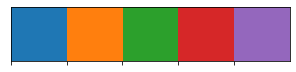

In [6]:
def best_cut(dendo, min_clust, max_clust):
    """
    :param dendo: Dendrogram
    :param min_clust: Nombre min de clusters
    :param max_clust: Nombre max de clusters
    :return: Nombre optimal de clusters selon le critère du saut d'inertie maximal
            et compris entre [min_clust, max_clust]
    """
    y_tab = []
    for i, d in zip(dendo['icoord'], dendo['dcoord']):
        y = d[1]
        y_tab.append(y)
    y_tab = sorted(y_tab)
    inertia = [y_tab[i+1] - y_tab[i] for i in range(len(y_tab)-1)]
    len_inertia = len(inertia)
    borne_min = max(0, len_inertia - max_clust + 1)
    borne_max = len_inertia - min_clust + 2
    return len_inertia - (np.argmax(inertia[borne_min:borne_max]) + borne_min) + 1

labels_y = []
vocabulary = dict()

seq_id = ''
with open("exp_ced/seqs.csv", encoding="windows-1252") as f:
  jump = False
  for line in f:
    if not jump:
      jump = True
      continue
    l = line.split(",")
    curr_id = l[1]
    if curr_id == seq_id:
      continue
    else:
      index = vocabulary.setdefault(l[0], len(vocabulary))
      labels_y.append(index)
      seq_id = curr_id
palette = sns.color_palette("tab10", max(labels_y) + 1)
sns.palplot(palette)
cl_map = {v : k for k,v in vocabulary.items()}
print(vocabulary)

In [7]:
CED_matrix = np.loadtxt("exp_ced/dis_matrix_ced.txt")
print(CED_matrix.shape)

ED_matrix = np.loadtxt("exp_ced/dis_matrix_ed.txt")
print(ED_matrix.shape)

LEV_matrix = np.loadtxt("exp_ced/dis_matrix_lev.txt")
print(LEV_matrix.shape)

(250, 250)
(250, 250)
(250, 250)


# Original Matrix Clustering

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """Entry point for launching an IPython kernel.


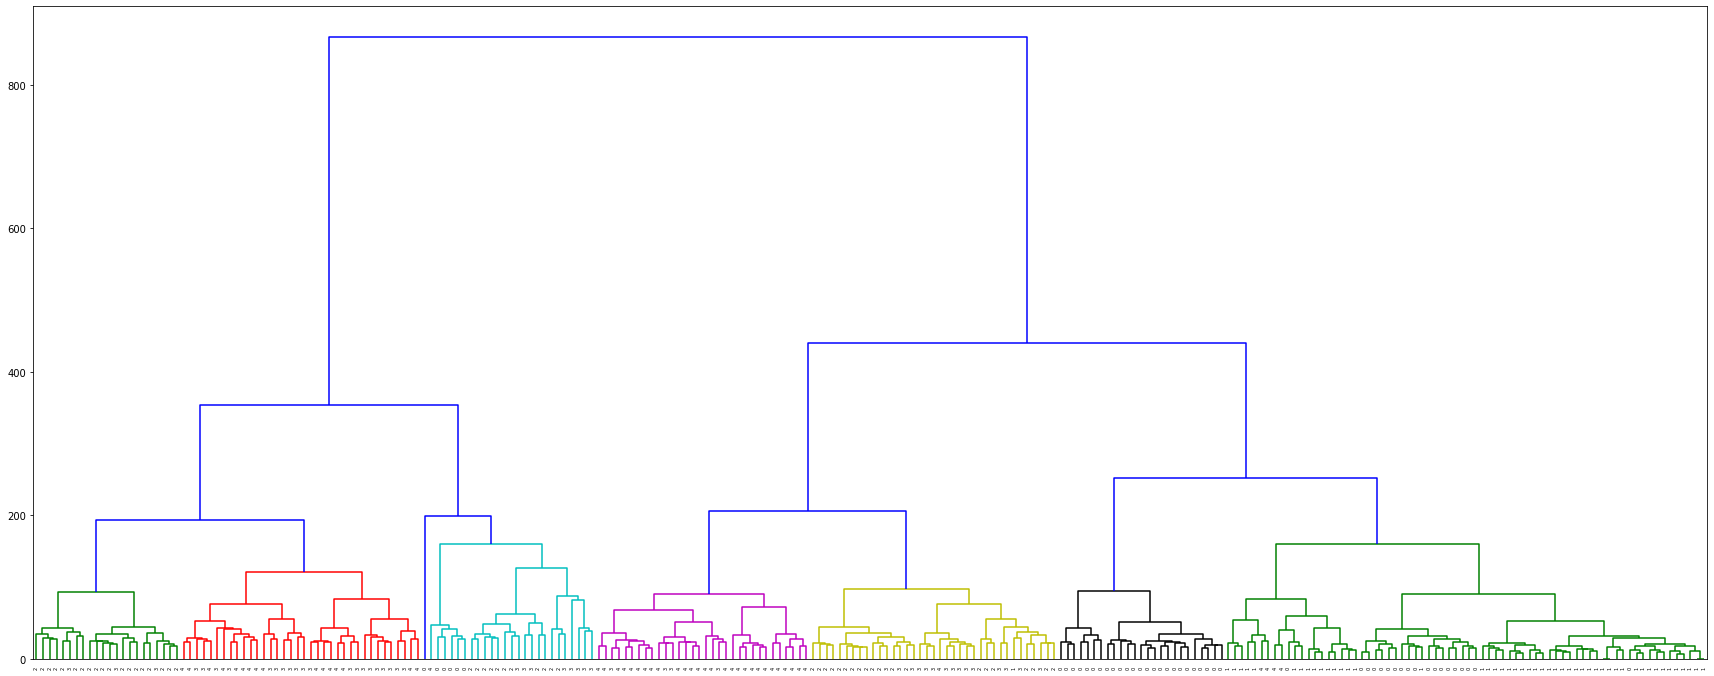

Cluster NB 5
ARI 0.31473361680600775


In [8]:
linkage_matrix = linkage(LEV_matrix, "ward")
#linkage_matrix = linkage(ED_matrix, "ward")
#linkage_matrix = linkage(CED_matrix, "ward")

plt.figure(figsize=(30,12))
dendo = dendrogram(linkage_matrix, labels=labels_y, truncate_mode=None, color_threshold=180)
plt.show()

#bc = best_cut(dendo, 4, 8)
groupes = fcluster(linkage_matrix, t=5, criterion='maxclust')
#assign = clusters_identity(groupes, labels_y)

print("Cluster NB", max(groupes))
print("ARI", ari(labels_y, groupes))

In [9]:
# Spectral
from sklearn.cluster import SpectralClustering
clusterer = SpectralClustering(n_clusters=5, affinity='precomputed')
aff = np.exp(- LEV_matrix ** 2 / (2. * (LEV_matrix.max()-LEV_matrix.min()) ** 2))
clusterer.fit(aff)
ari(labels_y, clusterer.labels_)

0.5102944786669271

In [10]:
# K-Medoid
from sklearn_extra.cluster import KMedoids
cl = KMedoids(n_clusters=5, init='k-medoids++')
cl.fit(CED_matrix)
ari(labels_y, cl.labels_)

0.38090213346288726

In [11]:
# DBSCAN + grid search for it's parameters
from sklearn.cluster import DBSCAN
params = []
perf = []
for e in range(1,50):
  eps = float(e)/10
  for ms in range(2,20):
    clustering = DBSCAN(eps=eps, min_samples=ms, metric='precomputed').fit(CED_matrix)
    params.append((eps, ms))
    perf.append(ari(labels_y, clustering.labels_))

best_id = np.argmax(perf)
print(params[best_id], perf[best_id])

(2.1, 12) 0.4093738104540934


# UMAP + Kmeans/Spectral

/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1736: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  "using precomputed metric; transform will be unavailable for new data and inverse_transform "
/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1736: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  "using precomputed metric; transform will be unavailable for new data and inverse_transform "
/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1736: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  "using precomputed metric; transform will be unavailable for new data and inverse_transform "


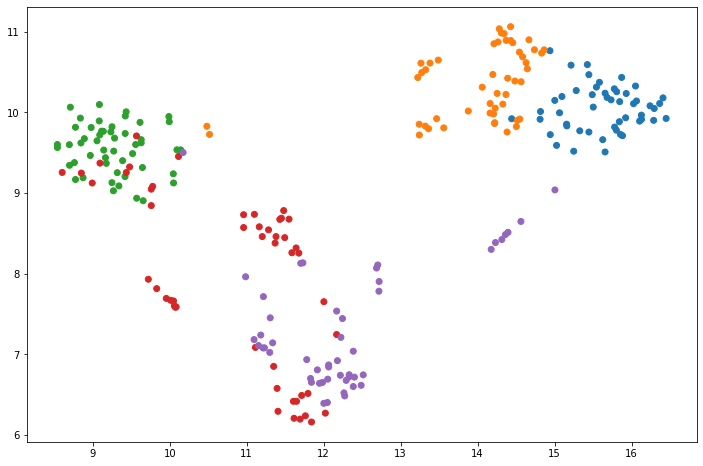

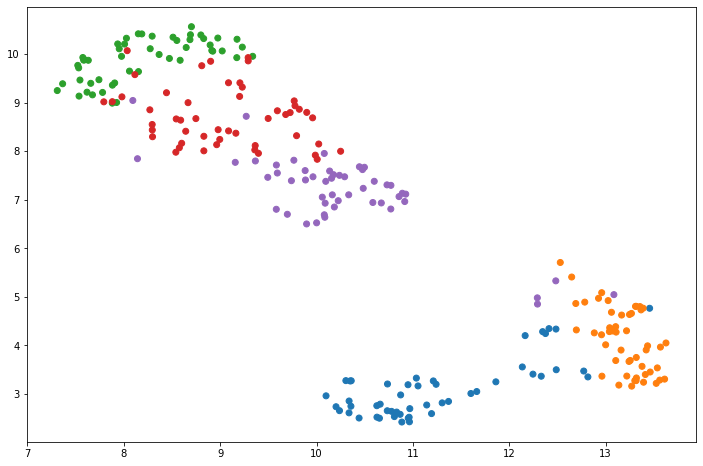

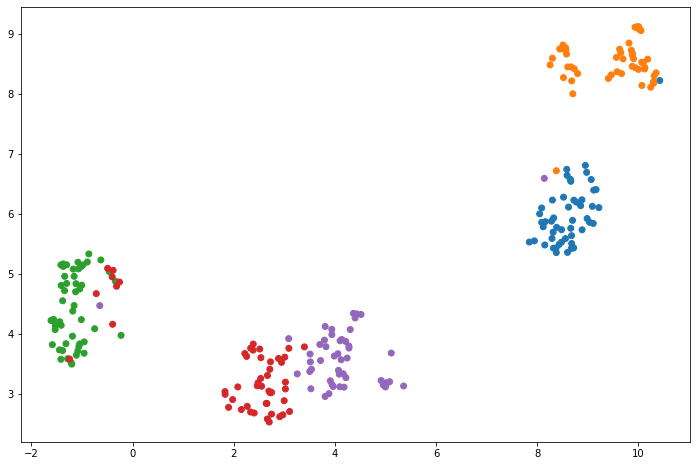

In [13]:
reducer = umap.UMAP(n_components=2, n_neighbors=25, random_state=42, min_dist=0.01, metric='precomputed')

masked_target = np.array(labels_y, dtype=np.int8)
masked_target[np.random.choice(250, size=200, replace=False)] = -1

embedding_CED = reducer.fit_transform(CED_matrix)
embedding_ED = reducer.fit_transform(ED_matrix)
embedding_LEV = reducer.fit_transform(LEV_matrix)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.scatter(embedding_LEV[:, 0], embedding_LEV[:, 1], c=[palette[x] for x in labels_y])
#plt.show()
#plt.savefig('umap_plot.pdf')

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.scatter(embedding_ED[:, 0], embedding_ED[:, 1], c=[palette[x] for x in labels_y])

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.scatter(embedding_CED[:, 0], embedding_CED[:, 1], c=[palette[x] for x in labels_y])

In [15]:
#K-Means on top of UMAP
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=0).fit(embedding_CED)
ari(labels_y, kmeans.labels_)

0.8585279020714712

In [16]:
#Spectral on top of UMAP
from sklearn.cluster import SpectralClustering
clusterer = SpectralClustering(n_clusters=5)
clusterer.fit(embedding_CED)
ari(labels_y, clusterer.labels_)

0.8585279020714712

In [17]:
#DBSACN on top of UMAP again grid search to find descent parameters
from sklearn.cluster import DBSCAN
params = []
perf = []
for e in range(1,50):
  eps = float(e)/10
  for ms in range(2,20):
    clustering = DBSCAN(eps=eps, min_samples=ms, metric='euclidean').fit(embedding_CED)
    params.append((eps, ms))
    perf.append(ari(labels_y, clustering.labels_))

best_id = np.argmax(perf)
print(params[best_id], perf[best_id])

(0.5, 15) 0.7657270412869424


# Random Tests
Not part of the paper

In [ ]:
# Medoid profile
from scipy.spatial.distance import euclidean
_SQRT2 = np.sqrt(2)
def hellinger2(p, q):
    return euclidean(np.sqrt(p), np.sqrt(q)) / _SQRT2

fetard = [0,	0,	0.1,	0,	0.05,	0,	0.05,	0.5,	0.3]
culturel = [0.25,	0.3,	0,	0,	0.3,	0,	0,	0.05,	0.1]
campeur = [0.05,	0.05,	0.3,	0.05,	0.1,	0.2,	0.25,	0,	0]
jeunes = [0.3,	0.05,	0.1,	0.05,	0.2,	0.1,	0.1,	0,	0.1]
gastronomie = [0.1,	0,	0,	0.5,	0.15,	0,	0,	0.15,	0.1]

profiles = [fetard, culturel, campeur, jeunes, gastronomie]

distances = []
for i in range(len(profiles)):
  line = []
  for j in range(len(profiles)):
    line.append(hellinger2(profiles[i], profiles[j]))
  distances.append(line)

dis = np.array(distances)
m = np.argmin(dis.sum(axis=1))
print(m)

In [ ]:
reducer_0 = umap.UMAP(n_components=2, n_neighbors=25, random_state=12, min_dist=0.01, metric='precomputed')
embedding_0 = reducer_0.fit_transform(LEV_matrix)
reducer_1 = umap.UMAP(n_components=2, n_neighbors=25, random_state=12, min_dist=0.01, metric='precomputed')
embedding_1 = reducer_1.fit_transform(ED_matrix)
reducer_2 = umap.UMAP(n_components=2, n_neighbors=25, random_state=12, min_dist=0.01, metric='precomputed')
embedding_2 = reducer_2.fit_transform(CED_matrix)

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1504: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  "using precomputed metric; transform will be unavailable for new data and inverse_transform "
/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1504: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  "using precomputed metric; transform will be unavailable for new data and inverse_transform "
/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1504: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  "using precomputed metric; transform will be unavailable for new data and inverse_transform "


In [ ]:
full = np.concatenate((embedding_0, embedding_1, embedding_2),axis=1)
kmeans = KMeans(n_clusters=5, random_state=0).fit(full)
ari(labels_y, kmeans.labels_)

0.7030164781010886

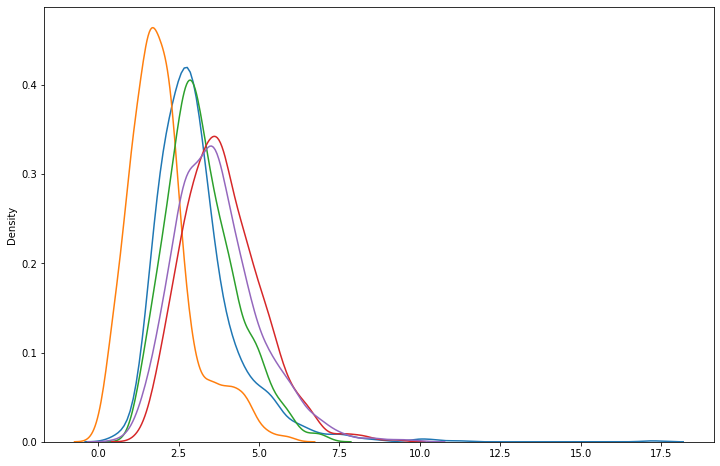

In [ ]:
# Distribution of ditances per class in CED Matrix
def dis_for_class(label):
  ids = np.array(labels_y)
  pos = np.argwhere(ids == label)[:,0]
  return CED_matrix[pos][:,pos]

plt.figure(figsize=(12,8))
for i in range (5):
  sns.kdeplot(squareform(dis_for_class(i)) ,  color=palette[i])
  #print("--- Class", cl_map[i], "---")
  #print(describe(squareform(dis_for_class(i))))